In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from dask.distributed import Client

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.paths import FIGURES_PATH, GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = FIGURES_PATH

Directory where results of expensive calculations will be stored:

In [6]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39529 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39529/status,
Dashboard: http://127.0.0.1:39529/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35247,Workers: 4
Dashboard: http://127.0.0.1:39529/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:42401,Total threads: 4
Dashboard: http://127.0.0.1:38933/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:46761,


In [9]:
map_parallel = get_map_parallel(client)

Input parameters

In [10]:
n_chains = len(lotka_volterra.theta_inits)

In [11]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [12]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [13]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_thinned_idx() -> list[np.ndarray]:
    raise NotImplemented

In [14]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def validation_hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [15]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_4.npy


# Gradient-free Stein thinning

In [16]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [17]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def rw_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, rw_samples[i])

In [18]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def hmc_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, hmc_samples[i])

## Full sample

### Laplace proxy

In [19]:
def laplace_approximation(logpdf, x0):
    res = minimize(lambda x: -logpdf(x), x0, method='BFGS', options={'gtol': 1e-3})
    assert res.success
    return res.x, res.hess_inv

In [20]:
%%time
laplace_mean, laplace_cov = laplace_approximation(lotka_volterra.log_target_density, np.mean(rw_samples[0], axis=0))

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_0.npy


CPU times: user 1.41 s, sys: 164 ms, total: 1.57 s
Wall time: 1.42 s


In [21]:
laplace_mean

array([-0.38253112,  0.29246496, -0.01989887, -0.01793044])

In [22]:
laplace_cov

array([[ 2.34793458e-05,  3.60158614e-05, -1.53824886e-05,
         3.46689365e-07],
       [ 3.60158614e-05,  6.56180950e-05, -2.12565683e-05,
        -2.70110977e-06],
       [-1.53824886e-05, -2.12565683e-05,  1.18664414e-05,
         4.49855438e-07],
       [ 3.46689365e-07, -2.70110977e-06,  4.49855439e-07,
         2.58154310e-06]])

In [23]:
def gaussian_thin(sample, log_p, mean, cov, thinned_size):
    log_q = mvn.logpdf(sample, mean=mean, cov=cov)
    gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(cov), sample - mean)
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size, range_cap=200)

The method clearly fails in this case:

In [24]:
gaussian_thin(rw_samples[0], rw_log_p[0], laplace_mean, laplace_cov, n_points_thinned)

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_log_p_0.npy
/home/artem/git/stein_thinning/stein_thinning/thinning.py:127: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231,
       231, 231, 231, 231, 231, 231, 231], dtype=uint32)

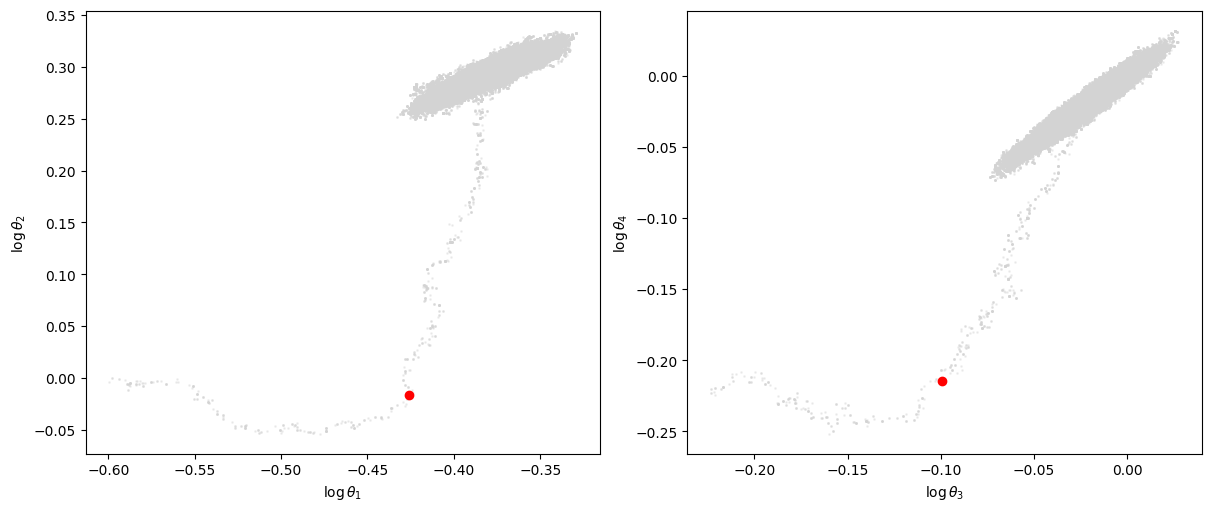

In [25]:
points_to_highlight = [231]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], points_to_highlight, [(0, 1), (2, 3)], axs, var_labels);

We calculate the proxy density at element 231:

In [26]:
log_q = mvn.logpdf(rw_samples[0], mean=laplace_mean, cov=laplace_cov)

In [27]:
log_q[231]

-26032762.34574922

In [28]:
rw_log_p[0][231]

-1290.111884958963

#### Numerical stability of optimisation

Using the default parameters in `scipy.optimize.minimize` results in a failure to find the optimum:

In [29]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -lotka_volterra.log_target_density(x), x0)
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -852.0640163220094
        x: [-3.825e-01  2.925e-01 -1.990e-02 -1.793e-02]
      nit: 9
      jac: [ 8.316e-04 -5.646e-04 -7.629e-06  2.441e-04]
 hess_inv: [[ 7.863e-06  1.394e-05 -2.236e-06  2.310e-06]
            [ 1.394e-05  3.830e-05 -1.929e-06 -1.293e-06]
            [-2.236e-06 -1.929e-06  9.404e-07 -1.463e-06]
            [ 2.310e-06 -1.293e-06 -1.463e-06  2.815e-06]]
     nfev: 160
     njev: 32

Nelder-Mead succeeds:

In [30]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -lotka_volterra.log_target_density(x), x0, method='Nelder-Mead')
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -852.0637592194984
             x: [-3.822e-01  2.926e-01 -2.023e-02 -1.826e-02]
           nit: 36
          nfev: 69
 final_simplex: (array([[-3.822e-01,  2.926e-01, -2.023e-02, -1.826e-02],
                       [-3.823e-01,  2.927e-01, -2.018e-02, -1.823e-02],
                       ...,
                       [-3.822e-01,  2.927e-01, -2.025e-02, -1.824e-02],
                       [-3.823e-01,  2.926e-01, -2.021e-02, -1.825e-02]]), array([-8.521e+02, -8.521e+02, -8.521e+02, -8.521e+02,
                       -8.521e+02]))

However, the Hessian evaluated at the maximum does not appear to be negative definite:

In [31]:
from numdifftools import Hessian

In [32]:
%%time
hess = Hessian(lotka_volterra.log_target_density)(res.x)
hess

CPU times: user 4.94 s, sys: 485 ms, total: 5.42 s
Wall time: 4.92 s


array([[-1196095.2214617 ,   329406.57616248, -1108270.83676384,
          106697.01289121],
       [  329406.57616248,  -118085.88891696,   257880.48682208,
           -6315.21068702],
       [-1108270.83676384,   257880.48682208, -1147544.69390286,
          228865.43619375],
       [  106697.01289121,    -6315.21068702,   228865.43619375,
          -97166.87432036]])

In [33]:
np.linalg.eigvals(hess)

array([-2381433.96995493,  -181583.12354665,    22522.02454574,
         -18397.60964605])

In [34]:
def is_positive_definite(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [35]:
is_positive_definite(-hess)

False

### Gaussian proxy

In [36]:
sample_mean = np.mean(rw_samples[0], axis=0)
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d)

In [37]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [38]:
sample_cov

array([[ 2.12987627e-04,  1.62995182e-04, -1.91636668e-04,
        -1.72343118e-04],
       [ 1.62995182e-04,  1.97250184e-04, -1.02375977e-04,
        -6.37599091e-05],
       [-1.91636668e-04, -1.02375977e-04,  2.16947410e-04,
         2.13353024e-04],
       [-1.72343118e-04, -6.37599091e-05,  2.13353024e-04,
         2.30906788e-04]])

In [39]:
idx = gaussian_thin(rw_samples[0], rw_log_p[0], sample_mean, sample_cov, n_points_thinned)
idx

/home/artem/git/stein_thinning/stein_thinning/thinning.py:127: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([427710, 149313, 490046, 428495, 183198,  80507, 268793, 367968,
       492726, 361480, 427710,  58196, 136691,  69676, 247516, 309270,
       427714,   3817,  15125, 293372], dtype=uint32)

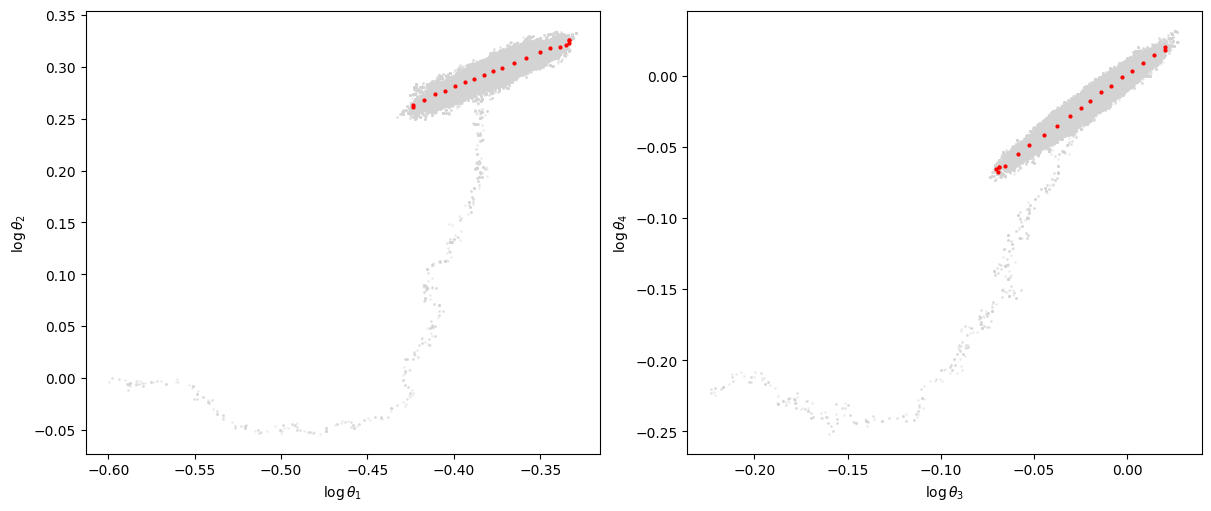

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

In [41]:
log_q = mvn.logpdf(rw_samples[0], mean=sample_mean, cov=sample_cov)
gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), rw_samples[0] - sample_mean)

In [42]:
np.ptp(log_q - rw_log_p[0])

12428.96517387056

### Student t proxy

In [43]:
from scipy.optimize import OptimizeResult
from scipy.special import gamma

In [44]:
def extract_t_params(par, d):
    # upper-triangular elements of an n-by-n matrix
    n_cov = d * (d + 1) // 2

    # the means of the multivariate t are in the first `d` elements
    mu = par[:d]
    # the upper triangular elements of A are in the following `n_cov` elements
    A = np.zeros((d, d))
    A[np.triu_indices(d)] = par[d:d + n_cov]
    # the scale matrix
    scale = A.T @ A
    # the degrees of freedom value is the last element of `par`
    df = par[d + n_cov]

    return mu, scale, df

def fit_mvt(
        Y: np.ndarray,
        mu_bounds: tuple[float, float],
        a_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu_init: np.ndarray = None,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables
    n_cov = d * (d + 1) // 2  # upper-triangular elements of an n-by-n matrix

    # the starting values for the search
    if mu_init is None:
        mu_init = np.mean(Y, axis=0)
    sample_cov = np.cov(Y, rowvar=False, ddof=d)
    A = np.linalg.cholesky(sample_cov).T
    start = np.concatenate([mu_init, A[np.triu_indices(d)], [df_init]])

    # the bounds for the search
    lower = np.array([mu_bounds[0]] * d + [a_bounds[0]] * n_cov + [df_bounds[0]])
    upper = np.array([mu_bounds[1]] * d + [a_bounds[1]] * n_cov + [df_bounds[1]])

    def loglik_mvt(Y: np.ndarray, par: np.ndarray) -> float:
        mu, scale, df = extract_t_params(par, Y.shape[1])
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=scale, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta)

    bounds = list(zip(lower, upper))

    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

def fit_mvt2(
        Y: np.ndarray,
        scale_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu: np.ndarray,
        scale_init: float = 0.0,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables

    # the starting values for the search
    sample_cov = np.cov(Y, rowvar=False, ddof=d)

    def loglik_mvt(Y: np.ndarray, scale, df) -> float:
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=np.exp(scale) * sample_cov, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta[0], beta[1])

    bounds = [scale_bounds, df_bounds]

    start = np.array([scale_init, df_init])
    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

In [45]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=OptimizeResult, recalculate=recalculate, persist=True)
def rw_t_fit() -> list[OptimizeResult]:
    # we have to instantiate the array here as the caching function currently cannot be serialised
    samples = list(rw_samples)
    def calculate(i):
        return fit_mvt(samples[i], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 15), df_init=3.)
    return map_parallel(calculate, range(len(theta_inits)))

Force recalculation when necessary:

In [46]:
#rw_t_fit.recalculate(persist=True);

In [47]:
%%time
fit = fit_mvt(rw_samples[0], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 30), df_init=4.)
fit

CPU times: user 5min 3s, sys: 6min 39s, total: 11min 43s
Wall time: 4min 11s


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -8155729.119366754
        x: [-3.826e-01  2.920e-01 ...  2.804e-03  1.289e+01]
      nit: 263
      jac: [ 7.629e+02  6.154e+03 ... -4.505e+03 -1.956e+00]
     nfev: 4544
     njev: 284
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>

In [48]:
t_mu, t_scale, t_df = extract_t_params(fit.x, lotka_volterra.d)

The density of the multivaritate Student's t distribution is given by
$$f(\mathbf{x}) = \frac{\Gamma\left(\frac{\nu + d}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \nu^{\frac{d}{2}} \pi^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}} \left[1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})\right]^{-\frac{\nu + d}{2}}.$$
The gradient of the log-density is then
$$\nabla_{\mathbf{x}} \log f(\mathbf{x}) = -\frac{\nu + d}{\nu} \frac{\Sigma^{-1} (\mathbf{x} - \pmb{\mu})}{1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})}$$

We implement the log-density of the multivariate t and confirm that it matches what is returned by `scipy`:

In [49]:
def t_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    return (
        np.log(gamma((df + d) / 2))
        - np.log(gamma(df  / 2))
        - d * (np.log(df) + np.log(np.pi)) / 2
        - np.log(np.linalg.det(sigma)) / 2
        -(df + d) / 2 * np.log(1 + np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu) / df)
    )

In [50]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=t_scale, df=t_df)

In [51]:
np.testing.assert_allclose(t_log_pdf(rw_samples[0], t_mu, t_scale, t_df), log_q)

In [52]:
def t_grad_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    direction_scaled = np.einsum('jk,ik->ij', sigma_inv, x_mu)
    mahalanobis_d = np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu)
    return -(df + d) / df / (1 + mahalanobis_d / df).reshape(-1, 1) * direction_scaled

In [53]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=t_scale, df=t_df)
gradient_q = t_grad_log_pdf(rw_samples[0], t_mu, t_scale, t_df)
thin_gf(rw_samples[0], rw_log_p[0], log_q, gradient_q, 100, range_cap=200)

array([268793, 193321, 490046, 149313, 162706, 164955, 136691,  84332,
       392297, 269558, 309148,  58196, 388084, 122231, 309276, 495415,
       199801, 313131,  51063, 368196, 166659, 344310, 465968, 427710,
       428061, 180763, 430204,  75114, 232523, 360185, 458015, 316013,
       304288, 392626, 400147, 162584, 165026, 427630, 466623, 136691,
       189684, 149670, 366525, 269509, 269287, 456125, 331751, 428210,
        73007, 412784, 136559, 462435, 431345, 360315, 360281, 269625,
       390618,  16713,  13502,  83189, 195618, 254593, 310026, 478495,
       328988, 361028,  98413, 358814, 268433,  17494, 136691, 399991,
        64234, 309289, 470265, 340597, 365032, 413832, 309297,  36953,
       427714, 428035, 408677, 406246, 373173, 353448, 443614,  48870,
       297324, 379998, 477051, 115027, 372203,   5312, 180088, 326712,
       331568, 329108, 306949, 197759], dtype=uint32)

In [54]:
np.ptp(log_q - rw_log_p[0])

15570.877124863659

In [55]:
sample_mode = rw_samples[0][np.argmax(rw_log_p[0])]
fit2 = fit_mvt2(rw_samples[0], scale_bounds=(-20, 20), df_bounds=(2, 30), mu=sample_mode)
fit2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -7701532.9296034295
        x: [-6.643e-01  9.456e+00]
      nit: 12
      jac: [-1.304e+00 -9.313e-02]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [56]:
t_mu = sample_mode
t_scale = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d) * np.exp(fit2.x[0])
t_df = fit2.x[1]

In [57]:
t_mu

array([-0.38262152,  0.2922964 , -0.01989471, -0.01783209])

In [58]:
t_scale

array([[ 1.09611833e-04,  8.38837489e-05, -9.86237875e-05,
        -8.86945656e-05],
       [ 8.38837489e-05,  1.01512724e-04, -5.26867153e-05,
        -3.28133639e-05],
       [-9.86237875e-05, -5.26867153e-05,  1.11649693e-04,
         1.09799881e-04],
       [-8.86945656e-05, -3.28133639e-05,  1.09799881e-04,
         1.18833740e-04]])

In [59]:
t_df

9.456167660133405

In [60]:
t_df = np.round(t_df)
t_df

9.0

In [61]:
def thin_gf_t(sample, log_p, t_mu, t_scale, t_df, thinned_size):
    log_q = stats.multivariate_t.logpdf(sample, loc=t_mu, shape=t_scale, df=t_df)
    gradient_q = t_grad_log_pdf(sample, t_mu, t_scale, t_df)
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size, range_cap=200)

In [62]:
idx = thin_gf_t(rw_samples[0], rw_log_p[0], t_mu, np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d) * 3, 4, 100)
idx

array([210376, 442969,  80507,  51956, 392030,  55794, 249886, 428495,
       284066, 397477,  58914, 113015,  19535, 341822, 349159, 430931,
       245786, 222623, 279220, 465968, 437304, 499762,  97484, 285752,
       318398, 366902, 392297, 173240, 192217, 246329,  32814, 430204,
       456038, 131209, 396729, 297862, 372321, 289076, 378348, 283826,
       215531, 274665, 236412, 411800, 493992, 164977, 449619, 464124,
       271127, 301248,  69014, 264791,  58495, 478448, 471186, 490046,
       396803, 359110, 468104, 439100, 160255, 317689, 142635, 413010,
       238704, 218919, 411041, 106757, 387864, 476932, 149313, 247965,
       387974, 433207, 139123, 474510, 259443, 418138, 430931,  92115,
        98812, 320672,  31205,  22933,  39812, 337220,  34004, 129779,
       269834, 460980, 465955, 115317, 325680, 389154, 311114, 141151,
       439171,  43873, 199242, 147363], dtype=uint32)

In [63]:
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d)
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=sample_cov * 3, df=4)
gradient_q = t_grad_log_pdf(rw_samples[0], t_mu, sample_cov * 3, lotka_volterra.d)
thin_gf(rw_samples[0], rw_log_p[0], log_q, gradient_q, 100, range_cap=200)

array([210376, 442969,  80507,  51956, 392030,  55794, 249886, 428495,
       284066, 397477,  58914, 113015,  19535, 341822, 349159, 430931,
       245786, 222623, 279220, 465968, 437304, 499762,  97484, 285752,
       318398, 366902, 392297, 173240, 192217, 246329,  32814, 430204,
       456038, 131209, 396729, 297862, 372321, 289076, 378348, 283826,
       215531, 274665, 236412, 411800, 493992, 164977, 449619, 464124,
       271127, 301248,  69014, 264791,  58495, 478448, 471186, 490046,
       396803, 359110, 468104, 439100, 160255, 317689, 142635, 413010,
       238704, 218919, 411041, 106757, 387864, 476932, 149313, 247965,
       387974, 433207, 139123, 474510, 259443, 418138, 430931,  92115,
        98812, 320672,  31205,  22933,  39812, 337220,  34004, 129779,
       269834, 460980, 465955, 115317, 325680, 389154, 311114, 141151,
       439171,  43873, 199242, 147363], dtype=uint32)

In [64]:
np.ptp(log_q - rw_log_p[0])

15622.255019330725

In [65]:
def fit_quality(subsample, validation_sample_step=10):
    return np.sqrt(dcor.energy_distance(validation_sample[::validation_sample_step], subsample))

In [66]:
fit_quality(rw_samples[0][rw_thinned_idx[0][:100]])

DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_thinned_idx_0.npy


0.10837416731318722

In [67]:
fit_quality(rw_samples[0][idx[:100]])

0.09488942311259109

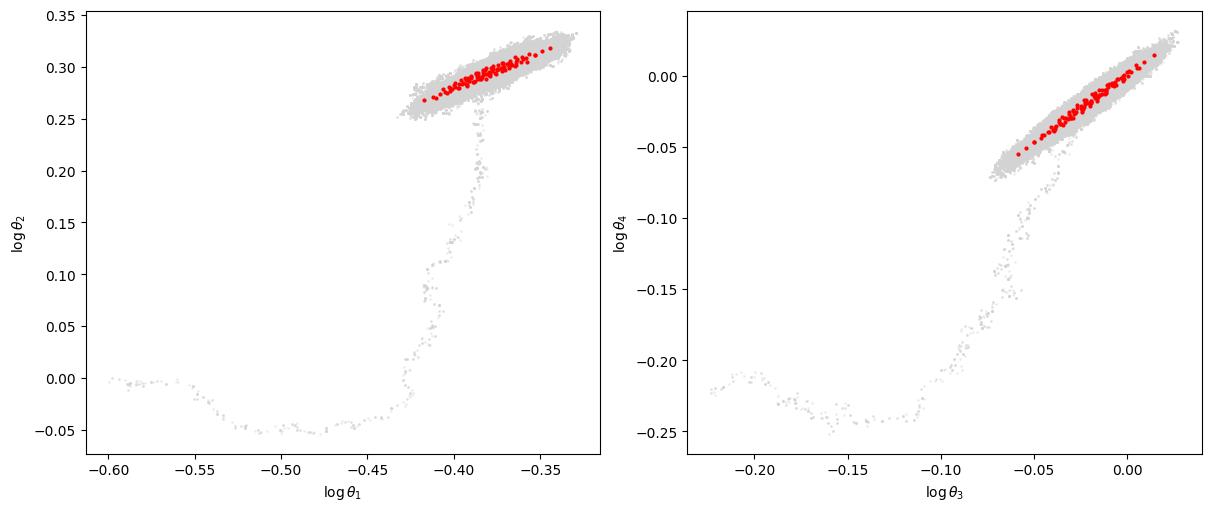

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

In [69]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_gf_t_idx() -> list[np.ndarray]:
    samples = list(rw_samples)
    log_ps = list(rw_log_p)
    t_fits = list(rw_t_fit)
    def calculate(i):
        t_mu, t_scale, t_df = extract_t_params(t_fits[i].x, d)
        return thin_gf_t(samples[i], log_ps[i], t_mu, t_scale, t_df, n_points_calculate)
    return map_parallel(calculate, range(len(theta_inits)))

In [70]:
#rw_gf_t_idx.recalculate(persist=True);

In [71]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_gf_t2_idx() -> list[np.ndarray]:
    samples = list(rw_samples)
    log_ps = list(rw_log_p)
    def calculate(i):
        sample_mode = samples[i][np.argmax(log_ps[i])]
        sample_cov = np.cov(samples[i], rowvar=False, ddof=d)
        return thin_gf_t(samples[i], log_ps[i], sample_mode, sample_cov * 3, 4, n_points_calculate)
    return map_parallel(calculate, range(len(theta_inits)))

In [72]:
#rw_gf_t2_idx.recalculate(persist=True);

In [73]:
i = 0
sample = rw_samples[i]
sample_cov = np.cov(sample, rowvar=False, ddof=lotka_volterra.d)
rescale_matrix = np.linalg.inv(scipy.linalg.sqrtm(sample_cov))
sample_rescaled = np.einsum('kj,ij->ik', rescale_matrix, sample)

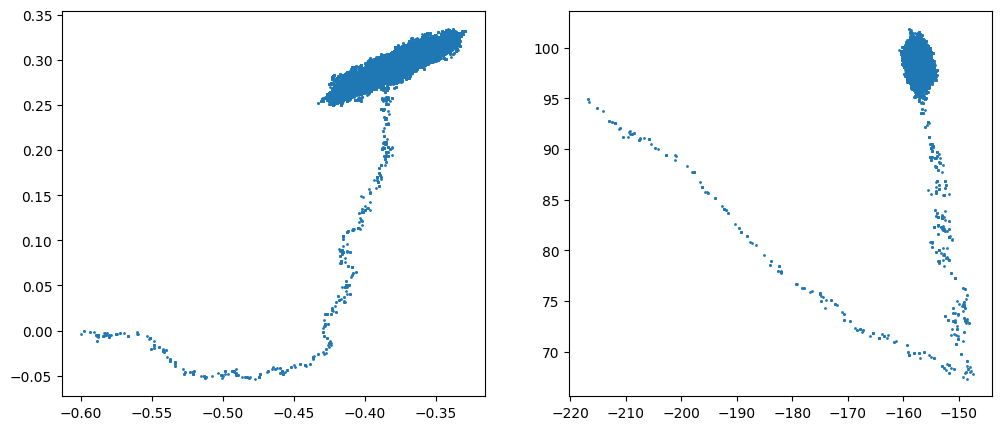

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(sample[:, 0], sample[:, 1], s=1);
axs[1].scatter(sample_rescaled[:, 0], sample_rescaled[:, 1], s=1);

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


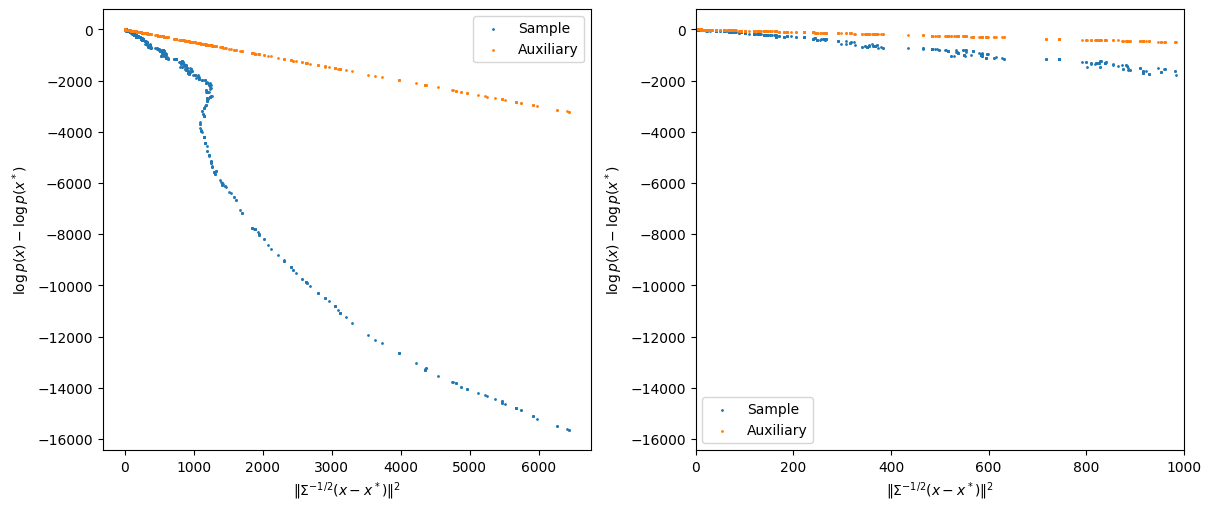

In [75]:
ref_idx = np.argmax(rw_log_p[i])
dists = cdist(sample_rescaled[ref_idx].reshape(1, -1), sample_rescaled).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

log_p_t = stats.multivariate_normal.logpdf(sample, mean=sample[ref_idx], cov=sample_cov)
prob_diff_t = log_p_t - log_p_t[ref_idx]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
axs[0].scatter(dists ** 2, prob_diff, s=1, label='Sample');
axs[0].scatter(dists ** 2, prob_diff_t, s=1, label='Auxiliary');
axs[0].set_xlabel('$\\|\\Sigma^{-1/2}(x - x^*) \\|^2$');
axs[0].set_ylabel('$\\log p(x) - \\log p(x^*)$');
axs[0].legend();

axs[1].scatter(dists ** 2, prob_diff, s=1, label='Sample');
axs[1].scatter(dists ** 2, prob_diff_t, s=1, label='Auxiliary');
axs[1].set_xlabel('$\\|\\Sigma^{-1/2}(x - x^*) \\|^2$');
axs[1].set_ylabel('$\\log p(x) - \\log p(x^*)$');
axs[1].set_xlim([0, 1000]);
axs[1].legend();

In [76]:
prob_diff_t

array([-3.21811660e+03, -3.21811660e+03, -3.20271497e+03, ...,
       -5.17925766e-01, -5.17925766e-01, -5.17925766e-01])

## Sample with burn-in removed manually

We plot the difference in log-probability versus the squared Euclidean distance from the sample mode:

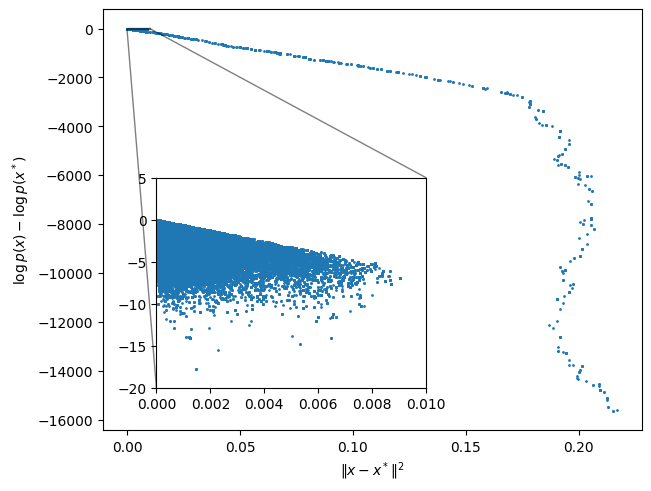

In [77]:
i = 0
sample = rw_samples[i]
sample_mean = np.mean(sample, axis=0)
ref_idx = np.argmax(rw_log_p[i])
dists = cdist(sample[ref_idx].reshape(1, -1), sample).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(dists ** 2, prob_diff, s=1);
ax.set_xlabel('$\\|x - x^* \\|^2$');
ax.set_ylabel('$\\log p(x) - \\log p(x^*)$');

inset_xlim = [0, 0.01]
inset_ylim = [-20, 5]

ax_ins = ax.inset_axes([0.1, 0.1, 0.5, 0.5], xlim=inset_xlim, ylim=inset_ylim)
ax.indicate_inset_zoom(ax_ins, edgecolor="black")

ax_ins.scatter(dists ** 2, prob_diff, s=1);
ax_ins.set_xlim(inset_xlim);
ax_ins.set_ylim(inset_ylim);

We can us the threshold of -15 to locate the bulk of the sample.

In [78]:
cond = prob_diff > -15 

This retains most of the points:

In [79]:
np.sum(cond) / rw_samples[0].shape[0]

0.9985880028239944

The resulting subsample:

In [80]:
subsample = rw_samples[0][cond]
subsample_log_p = rw_log_p[0][cond]

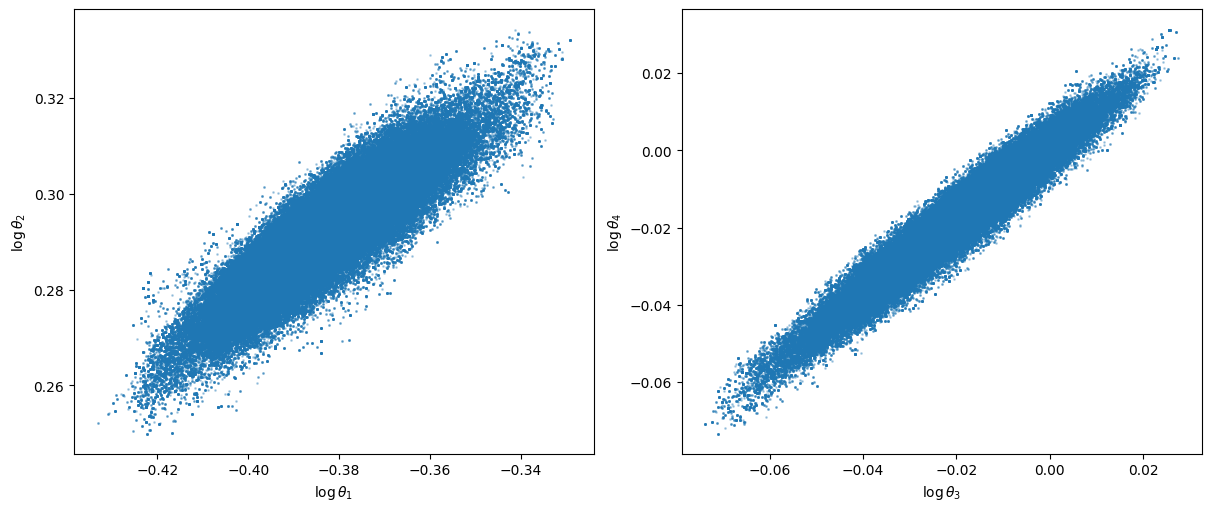

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, [], [(0, 1), (2, 3)], axs, var_labels, sample_point_color=None);

### Laplace proxy

The parameters of the Laplace proxy do not change, since they are estimated from the posterior distribution rather than the sample.

Thinning fails in this case again:

In [82]:
gaussian_thin(subsample, subsample_log_p, laplace_mean, laplace_cov, n_points_thinned)

array([426876, 426876, 426876, 426876, 426876, 426876, 426876, 426876,
       426876, 426876, 426876, 426876, 426876, 426876, 426876, 426876,
       426876, 426876, 426876, 426876], dtype=uint32)

In [83]:
subsample_log_p[426876]

844.9508392811421

In [84]:
subsample_log_q = mvn.logpdf(subsample, mean=laplace_mean, cov=laplace_cov)

In [85]:
subsample_log_q[426876]

-2222650.067328276

Again, the tail of the proxy distribution is too thin relative to the target.

### Gaussian proxy

In [86]:
subsample_mean = np.mean(subsample, axis=0)
subsample_cov = np.cov(subsample, rowvar=False, ddof=lotka_volterra.d)

In [87]:
subsample_mean

array([-0.3825417 ,  0.29205248, -0.02000333, -0.01804386])

In [88]:
subsample_cov

array([[ 0.00020368,  0.0001405 , -0.00020228, -0.0001877 ],
       [ 0.0001405 ,  0.00012273, -0.00013094, -0.00011424],
       [-0.00020228, -0.00013094,  0.00020522,  0.00019451],
       [-0.0001877 , -0.00011424,  0.00019451,  0.00019704]])

The values calculated from the subsample are very close to those obtained from the full sample:

In [89]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [90]:
sample_cov

array([[ 2.12987627e-04,  1.62995182e-04, -1.91636668e-04,
        -1.72343118e-04],
       [ 1.62995182e-04,  1.97250184e-04, -1.02375977e-04,
        -6.37599091e-05],
       [-1.91636668e-04, -1.02375977e-04,  2.16947410e-04,
         2.13353024e-04],
       [-1.72343118e-04, -6.37599091e-05,  2.13353024e-04,
         2.30906788e-04]])

In [91]:
idx = gaussian_thin(subsample, subsample_log_p, subsample_mean, subsample_cov, n_points_thinned)
idx

array([308570, 180846, 308583, 148608, 488658, 199095, 288880, 308442,
       367029, 435695, 192615, 268581, 308647, 180846, 431046, 319012,
        71864, 404187, 135986, 493971], dtype=uint32)

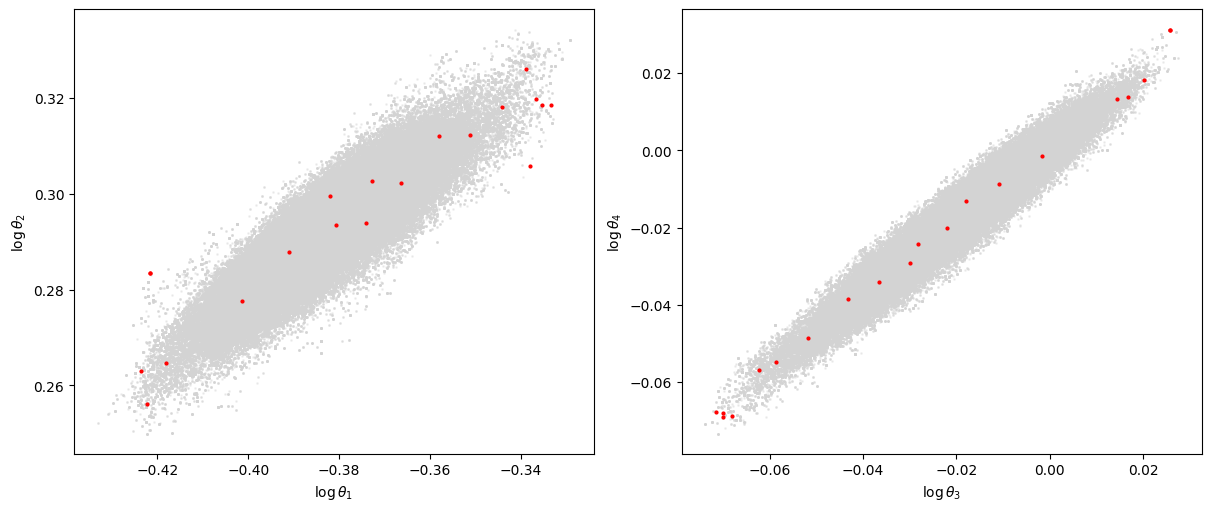

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

Notebook execution took:

In [93]:
time.time() - start_time

402.0143208503723